# Voting methods

This notebook compares a number of common voting methods. We are going to be using 2D images to visualize how different voting schemes work in different types of elections; this method is blatantly stolen from [Ka-Ping Yee's fantastic research](http://zesty.ca/voting/sim/). Each pixel in an image represents an election run with that pixel's coordinates as the centerpoint of public opinion, with voters normally distributed around that point. We are going to shrink our electoral base and only use 10,000 voters instead of 200,000 voters per election. Voters will prefer candidates that are closest in the space, with the order of preference determined by distance from the voter.

In [13]:
from math import sqrt

def distance(voter, candidate):
    return sqrt((voter['x'] - candidate['x'])**2 + (voter['y'] - candidate['y'])**2)

voter1 = {'x': 0.5, 'y': 1.5}
candidate1 = {'x': 1.0, 'y': 2.0}
candidate2 = {'x': 4.0, 'y': 4.0}

assert distance(voter1, candidate1) < distance(voter1, candidate2)

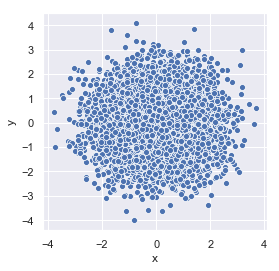

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

def generate_population(x, y, n=10000, sigma=1):
    return [{'x': t[0], 'y': t[1]} for t in zip(np.random.normal(x, sigma, n), np.random.normal(y, sigma, n))]

voters = pd.DataFrame(generate_population(0, 0))
sns.set(rc={'figure.figsize':(4, 4)})
sns.scatterplot(x='x', y='y', data=voters)

There are two main categories of voting systems: ordinal and cardinal. In ordinal systems, voters rank the candidates in an order of preference. In cardinal systems, voters assign a score to each candidate to represent the magnitude of preference as well.

First, we will implement plurality voting, the simplest form of ordinal voting. It is simple and will be familiar to anybody living in the United States. Voters use a single vote to select their most-preferred candidate, and the candidate with the most votes wins.

In [15]:
from collections import Counter
from matplotlib.colors import BASE_COLORS as colors

def plurality(voters, candidates):
    votes = []
    
    for voter in voters:
        selection = min(candidates, key=lambda c: distance(voter, c))
        votes.append(selection)
    
    return max(votes, key=votes.count)

def cand(x, y, color):
    return {'x': x, 'y': y, 'color': color}

candidates = [cand(0, 0, colors['b']), cand(2, 2, colors['y'])]
plurality(generate_population(0, 0), candidates)

{'x': 0, 'y': 0, 'color': (0, 0, 1)}

In [16]:
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

def run_system(candidates, size=128, system=plurality):
    arr = np.zeros((size, size, 3), dtype=np.uint8)
    
    elections = [(x, y) for x in range(size) for y in range(size)]
    
    for election in tqdm(elections):
            winner = system(generate_population(*election), candidates)
            arr[election[0]][election[1]] = winner['color']
            
    return arr
    
img = run_system(candidates, size=128)
plt.imshow(img)

KeyboardInterrupt: 